Code from: https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F# define NN architecture

import matplotlib.pyplot as plt


In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor
transform = transforms.ToTensor()# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 80592919.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66448542.96it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32426043.44it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12994903.66it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



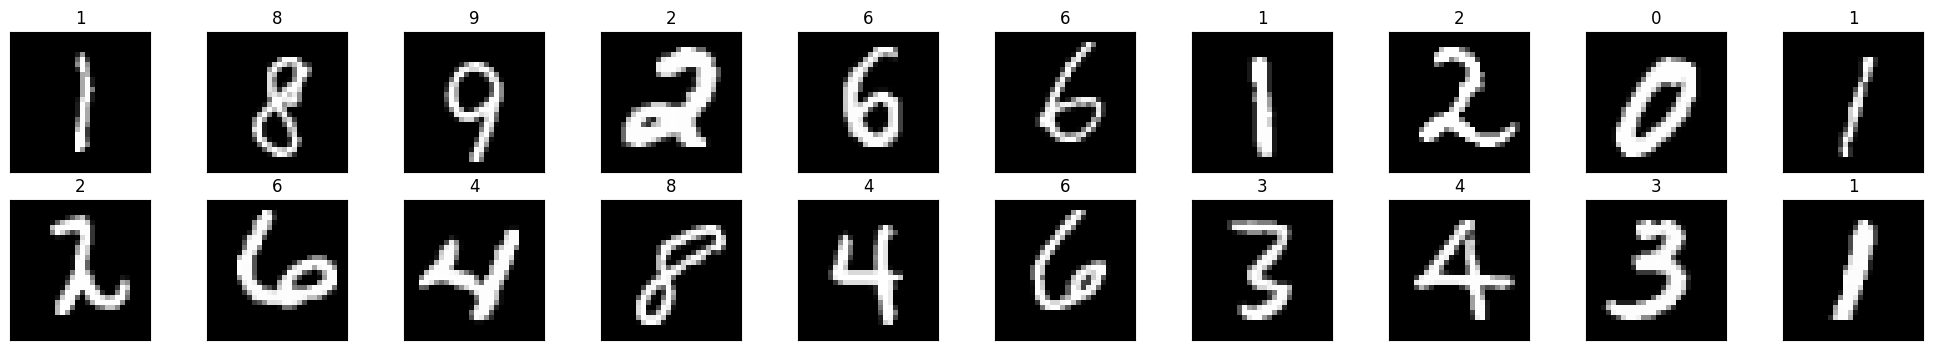

In [5]:

%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

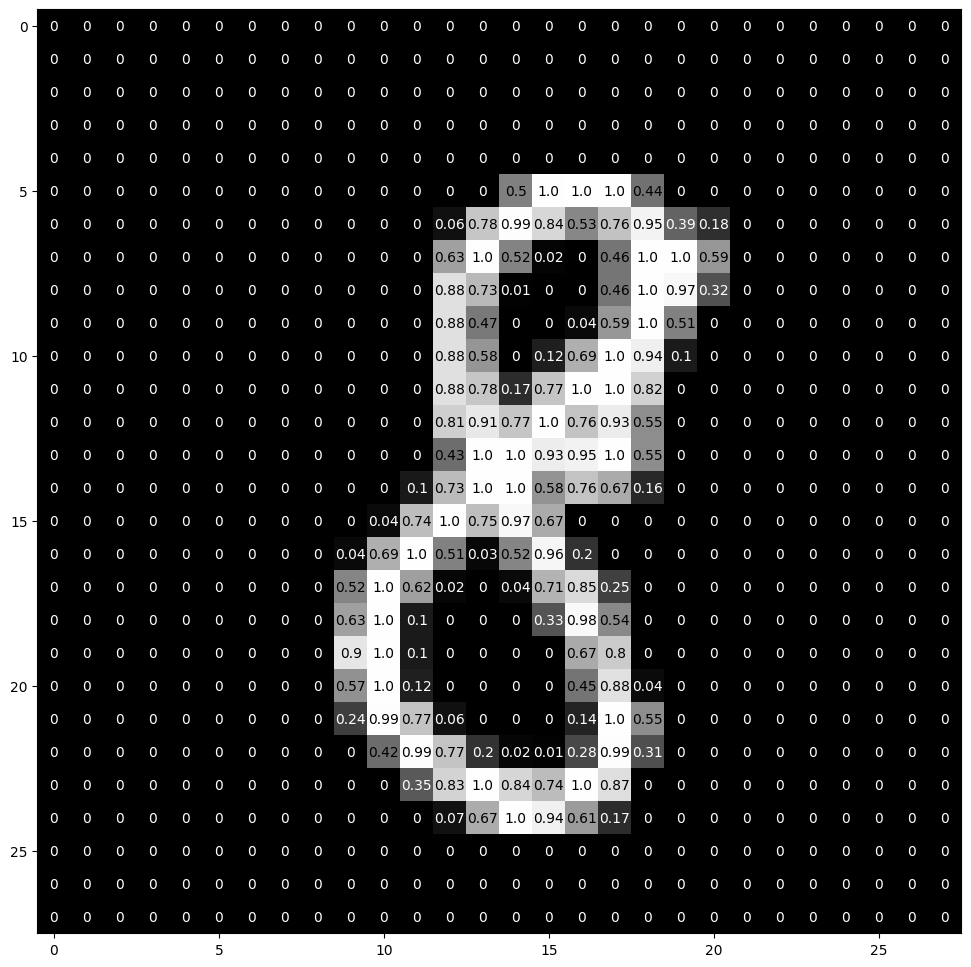

In [6]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)

    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [8]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)



In [9]:
# number of epochs to train the model
n_epochs = 5  # initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0


    ###################
    # train the model #
    ###################
    itter = 0
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        itter+=1
        print('Training - Epoch: {} \t Itter: {} \t Batch_Loss: {}'.format(epoch+1, itter,loss.item()))

     ######################
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss
        valid_loss = loss.item() * data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Streaming output truncated to the last 5000 lines.
Training - Epoch: 4 	 Itter: 260 	 Batch_Loss: 0.2827548682689667
Training - Epoch: 4 	 Itter: 261 	 Batch_Loss: 0.5300024747848511
Training - Epoch: 4 	 Itter: 262 	 Batch_Loss: 0.45800477266311646
Training - Epoch: 4 	 Itter: 263 	 Batch_Loss: 0.4332060217857361
Training - Epoch: 4 	 Itter: 264 	 Batch_Loss: 0.35185083746910095
Training - Epoch: 4 	 Itter: 265 	 Batch_Loss: 0.2877345085144043
Training - Epoch: 4 	 Itter: 266 	 Batch_Loss: 0.39304348826408386
Training - Epoch: 4 	 Itter: 267 	 Batch_Loss: 0.4230138063430786
Training - Epoch: 4 	 Itter: 268 	 Batch_Loss: 0.27911415696144104
Training - Epoch: 4 	 Itter: 269 	 Batch_Loss: 0.26940158009529114
Training - Epoch: 4 	 Itter: 270 	 Batch_Loss: 0.38920173048973083
Training - Epoch: 4 	 Itter: 271 	 Batch_Loss: 0.39145541191101074
Training - Epoch: 4 	 Itter: 272 	 Batch_Loss: 0.2578240931034088
Training - Epoch: 4 	 Itter: 273 	 Batch_Loss: 0.44675377011299133
Training - Epoch: